# 검증결과: 0.977
- 모델링기록.ipynb를 기반으로 최종 모델을 선정완료하여 06월 23일 실시한 검증결과를 도출한 모델을 담음.
- 최종 제출용 분석코드 

# 패키지 임포트

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

import os
import pickle

import sklearn
print("싸이킷런 버젼: ", sklearn.__version__)
import lightgbm
print("LGBM 버젼: ", lightgbm.__version__)

import datetime

싸이킷런 버젼:  1.2.2
LGBM 버젼:  4.2.0


# 데이터 전처리 및 EDA

In [65]:
train=pd.read_csv('electric_train.csv', index_col=0).reset_index(drop=True)
display(train.head())

,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
0,4821,2021-01-01 01:00:00,1,11,884,6950,751.32,68.606449,2.2,62.7,1.8,0.0,-1.0,4,0,99.56
1,4821,2021-01-01 02:00:00,2,11,884,6950,692.60,68.606449,2.3,63.1,2.1,0.0,-0.6,4,0,91.78
2,4821,2021-01-01 03:00:00,3,11,884,6950,597.48,68.606449,2.2,62.4,2.5,0.0,-1.3,4,0,79.17
3,4821,2021-01-01 04:00:00,4,11,884,6950,553.48,68.606449,1.7,63.5,1.7,0.0,-0.2,4,0,73.34
4,4821,2021-01-01 05:00:00,5,11,884,6950,526.24,68.606449,1.7,63.0,1.6,0.0,-0.8,4,0,69.73


In [5]:
print("훈련데이터 타입, 길이, 컬럼명 확인")
print(train.info())

훈련데이터 타입, 길이, 컬럼명 확인
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593355 entries, 0 to 7593354
Data columns (total 16 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   electric_train.num          int64  
 1   electric_train.tm           object 
 2   electric_train.hh24         int64  
 3   electric_train.n            int64  
 4   electric_train.stn          int64  
 5   electric_train.sum_qctr     int64  
 6   electric_train.sum_load     float64
 7   electric_train.n_mean_load  float64
 8   electric_train.nph_ta       float64
 9   electric_train.nph_hm       float64
 10  electric_train.nph_ws_10m   float64
 11  electric_train.nph_rn_60m   float64
 12  electric_train.nph_ta_chi   float64
 13  electric_train.weekday      int64  
 14  electric_train.week_name    int64  
 15  electric_train.elec         float64
dtypes: float64(8), int64(7), object(1)
memory usage: 926.9+ MB
None


In [3]:
submit= pd.read_csv('electric_test.csv')
display(submit.head())

,NUM,TM,HH24,STN,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elect
0,4816,2023-01-01 01:00:00,1,752,3.0,68.6,2.9,0.0,-0.1,6,1.0,NaN
1,4816,2023-01-01 02:00:00,2,752,3.1,69.4,2.7,0.0,0.3,6,1.0,NaN
2,4816,2023-01-01 03:00:00,3,752,3.6,68.3,2.3,0.0,1.2,6,1.0,NaN
3,4816,2023-01-01 04:00:00,4,752,4.0,69.2,3.1,0.0,1.1,6,1.0,NaN
4,4816,2023-01-01 05:00:00,5,752,4.2,69.5,2.5,0.0,2.0,6,1.0,NaN


In [7]:
print("제출데이터 타입, 길이, 컬럼명 확인")
print(submit.info())

제출데이터 타입, 길이, 컬럼명 확인
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2829478 entries, 0 to 2829477
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   NUM         int64  
 1   TM          object 
 2   HH24        int64  
 3   STN         int64  
 4   nph_ta      float64
 5   nph_hm      float64
 6   nph_ws_10m  float64
 7   nph_rn_60m  float64
 8   nph_ta_chi  float64
 9   weekday     int64  
 10  week_name   float64
 11  elect       float64
dtypes: float64(7), int64(4), object(1)
memory usage: 259.0+ MB
None


## 전력기상지수
- EDA 결과: 1) 이상치로 보이는 최고값, 2) 결측치로 보이는 최저값
<pre>
    최고값 대체해야할 이상치(2건): 경향에서 벗어남
    1.
    전력기상지수 최고값:  373.06
    전력기상지수 최고값의 인덱스:  2870785
    최고값의 num:  14092
    최고값의 tm:  2022-05-30
    2.
    전력기상지수 이상치로 추정되는 값:  electric_train.elec    284.4
    전력기상지수 이상치로 추정되는 값의 인덱스:  1864987
    이상치로 추정되는 값의 num:  12467
    이상치로 추정되는 값의 tm:  2021-09-12
</pre>
- -99에 해당하는 5건 대체해야함

In [8]:
y=train['electric_train.elec']
path="./시각화/"

In [9]:
print( "기술통계량 확인\n",y.describe().apply(lambda x: np.round(x,3)))

기술통계량 확인
 count    7593355.00
mean         100.00
std           25.12
min          -99.00
25%           82.22
50%           95.70
75%          114.64
max          373.06
Name: electric_train.elec, dtype: float64


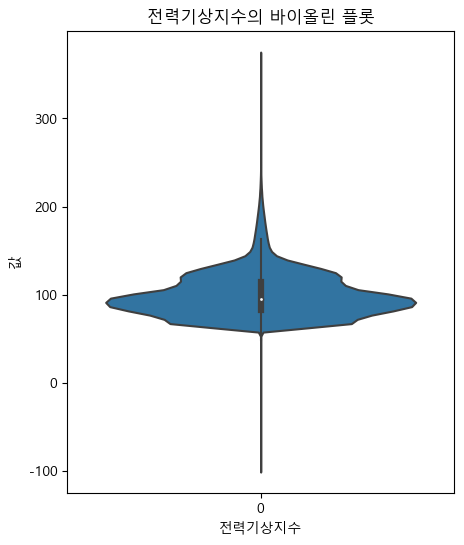

In [10]:
plt.figure(figsize=(5,6))
sns.violinplot(y)
plt.xlabel('전력기상지수')
plt.ylabel("값")
plt.title("전력기상지수의 바이올린 플롯")
plt.savefig(path+"전력기상지수_바이올린플롯.png")
plt.show()

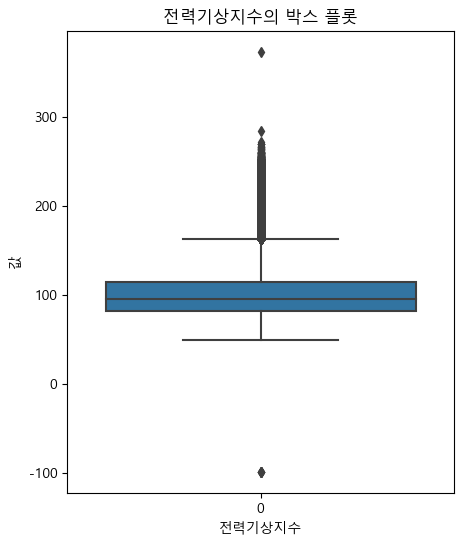

In [11]:
plt.figure(figsize=(5,6))
sns.boxplot(y)
plt.xlabel('전력기상지수')
plt.ylabel("값")
plt.title("전력기상지수의 박스 플롯")
plt.savefig(path+"전력기상지수_박스플롯.png")
plt.show()

In [12]:
print("이상치 확인(IQR) 및 대체해야하는지 결정")
iqr =y.quantile(0.75) - y.quantile(0.25)
iqrMax = iqr*1.5 + y.quantile(0.75)
iqrMin = y.quantile(0.25) - iqr*1.5
print("상한 초과 이상치 개수: ", len(y[y>iqrMax]))
print("하한 미만 이상치 개수: ", len(y[y<iqrMin]))

del iqr, iqrMax, iqrMin

이상치 확인(IQR) 및 대체해야하는지 결정
상한 초과 이상치 개수:  182659
하한 미만 이상치 개수:  5


전력기상지수 최고값:  373.06
전력기상지수 최고값의 인덱스:  2870785
최고값의 num:  14092
최고값의 tm:  2022-05-30


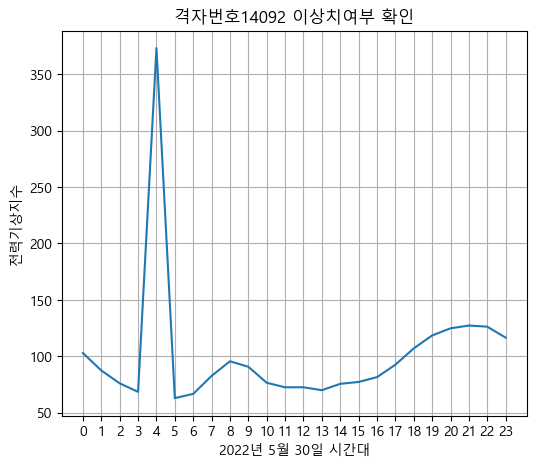

In [13]:
# 최고치 값 확인: num과 일자(일)이 같은 부분 확인
print("전력기상지수 최고값: ",y.max())
print("전력기상지수 최고값의 인덱스: ",y.idxmax())
yMaxNum = train.loc[y.idxmax()]['electric_train.num']
yMaxTm = train.loc[y.idxmax()]['electric_train.tm'][:10]
print("최고값의 num: ", yMaxNum)
print("최고값의 tm: ", yMaxTm)

cond1= train['electric_train.num'] == yMaxNum
cond2= train['electric_train.tm'].apply(lambda x: x[:10]) == yMaxTm
checkOutlier = train[cond1 & cond2]['electric_train.elec']

plt.figure(figsize=(6,5))
plt.plot([i for i in range(len(checkOutlier))], checkOutlier.values)
plt.xticks([i for i in range(len(checkOutlier))])
plt.xlabel("2022년 5월 30일 시간대")
plt.ylabel("전력기상지수")
plt.title("격자번호14092 이상치여부 확인")
plt.grid(True)
plt.savefig(path+"이상치판단(최고값).png")
plt.show()

del yMaxNum,yMaxTm, cond1, cond2, checkOutlier

In [ ]:
yTop10=y.reset_index().sort_values(by='electric_train.elec', ascending=False ,ignore_index=True).iloc[:10]
yTop10=yTop10.set_index('index')
yTop10
for idx , elec in yTop10.iterrows():
    print("전력기상지수 이상치로 추정되는 값: ", elec)
    print("전력기상지수 이상치로 추정되는 값의 인덱스: ",idx)
    idxNum = train.loc[idx]['electric_train.num']
    idxTm = train.loc[idx]['electric_train.tm'][:10]
    print("이상치로 추정되는 값의 num: ", idxNum)
    print("이상치로 추정되는 값의 tm: ", idxTm)
    
    cond1= train['electric_train.num'] == idxNum
    cond2= train['electric_train.tm'].apply(lambda x: x[:10]) == idxTm
    checkOutlier = train[cond1 & cond2]['electric_train.elec']
    
    plt.figure(figsize=(6,5))
    plt.plot([i for i in range(len(checkOutlier))], checkOutlier.values)
    plt.xticks([i for i in range(len(checkOutlier))])
    plt.xlabel(f"{idxTm} 시간대")
    plt.ylabel("전력기상지수")
    plt.title(f"격자번호{idxNum} 이상치 경향성 확인")
    plt.grid(True)
    # plt.savefig(path+"이상치판단.png")
    plt.show()
del yTop10, idx, elec, idxNum, idxTm, cond1, cond2, checkOutlier

In [15]:
print("최소값 -99 파악")
print(y[y==-99])
display(train.loc[y[y==-99].index])

최소값 -99 파악
1395082   -99.0
3026694   -99.0
3627062   -99.0
6092442   -99.0
7482518   -99.0
Name: electric_train.elec, dtype: float64


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
1395082,11412,2020-02-10 12:00:00,12,12,899,24700,12216.00,379.334179,11.5,48.4,1.6,0.0,7.9,0,0,-99.0
3026694,14258,2021-03-10 09:00:00,9,13,138,38400,21310.52,444.963932,10.5,62.3,5.7,0.0,10.5,2,0,-99.0
3627062,15735,2022-08-28 17:00:00,17,23,136,31240,27714.20,207.317978,26.4,45.3,2.5,0.0,26.2,6,1,-99.0
6092442,18680,2020-10-27 23:00:00,23,40,511,43200,22398.00,190.687836,8.7,92.0,0.4,0.0,12.8,1,0,-99.0
7482518,19724,2020-05-11 20:00:00,20,11,99,12200,20794.12,200.045791,18.2,74.7,4.8,0.0,15.9,0,0,-99.0


전력기상지수 최소값:  -99.0
전력기상지수 최소값의 인덱스:  1395082
최소값의 num:  11412
최소값의 tm:  2020-02-10


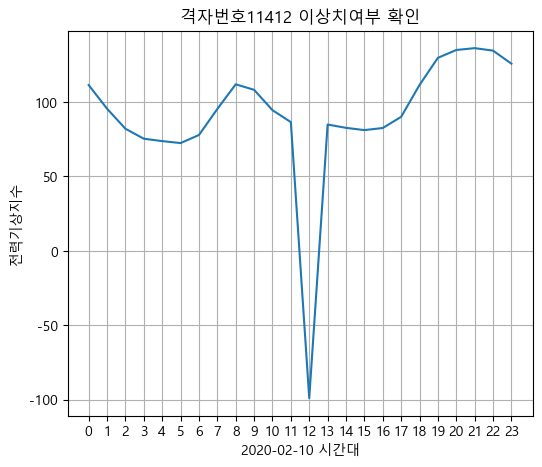

In [16]:
# 최고치 값 확인: num과 일자(일)이 같은 부분 확인
print("전력기상지수 최소값: ",y.min())
print("전력기상지수 최소값의 인덱스: ",y.idxmin())
yMinNum = train.loc[y.idxmin()]['electric_train.num']
yMinTm = train.loc[y.idxmin()]['electric_train.tm'][:10]
print("최소값의 num: ", yMinNum)
print("최소값의 tm: ", yMinTm)

cond1= train['electric_train.num'] == yMinNum
cond2= train['electric_train.tm'].apply(lambda x: x[:10]) == yMinTm
checkOutlier = train[cond1 & cond2]['electric_train.elec']

plt.figure(figsize=(6,5))
plt.plot([i for i in range(len(checkOutlier))], checkOutlier.values)
plt.xticks([i for i in range(len(checkOutlier))])
plt.xlabel(f"{yMinTm} 시간대")
plt.ylabel("전력기상지수")
plt.title(f"격자번호{yMinNum} 이상치여부 확인")
plt.grid(True)
plt.savefig(path+"이상치판단(최소값).png")
plt.show()

del yMinNum,yMinTm, cond1, cond2, checkOutlier

### 전력기상지수 이상치 및 결측치 처리
- 최고2순위 까지의 값과 -99에 해당하는 값을 이전 시간 및 이후 시간의 평균으로 대치.

In [17]:
imputeIndex=y[y==-99].index.tolist()
imputeIndex.append(2870785)
imputeIndex.append(1864987)
print("대치할 인덱스: ", imputeIndex)

for idx in imputeIndex:
    print(f"{idx} 대치 수행")
    print("대치할 행과 그 앞과 뒤의 행")
    display(train.iloc[[idx-1,idx,idx+1]])
    yPrev = train.loc[idx-1]['electric_train.elec']
    yNext = train.loc[idx+1]['electric_train.elec']
    yAgv = (yPrev+yNext) / 2
    
    train.at[idx,'electric_train.elec']=yAgv
    print()
    print("대치 확인")
    display(train.iloc[[idx-1,idx,idx+1]])
    print("-"*100,end='\n\n')
del idx, yPrev,yNext, yAgv

대치할 인덱스:  [1395082, 3026694, 3627062, 6092442, 7482518, 2870785, 1864987]
1395082 대치 수행
대치할 행과 그 앞과 뒤의 행


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
1395081,11412,2020-02-10 11:00:00,11,12,899,24700,3939.32,379.334179,10.7,50.9,1.2,0.0,5.9,0,0,86.54
1395082,11412,2020-02-10 12:00:00,12,12,899,24700,12216.00,379.334179,11.5,48.4,1.6,0.0,7.9,0,0,-99.00
1395083,11412,2020-02-10 13:00:00,13,12,899,24700,3865.48,379.334179,11.5,44.9,1.5,0.0,9.4,0,0,84.92



대치 확인


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
1395081,11412,2020-02-10 11:00:00,11,12,899,24700,3939.32,379.334179,10.7,50.9,1.2,0.0,5.9,0,0,86.54
1395082,11412,2020-02-10 12:00:00,12,12,899,24700,12216.00,379.334179,11.5,48.4,1.6,0.0,7.9,0,0,85.73
1395083,11412,2020-02-10 13:00:00,13,12,899,24700,3865.48,379.334179,11.5,44.9,1.5,0.0,9.4,0,0,84.92


----------------------------------------------------------------------------------------------------

3026694 대치 수행
대치할 행과 그 앞과 뒤의 행


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
3026693,14258,2021-03-10 08:00:00,8,13,138,38400,6028.08,444.963932,9.8,56.7,4.7,0.0,7.4,2,0,104.21
3026694,14258,2021-03-10 09:00:00,9,13,138,38400,21310.52,444.963932,10.5,62.3,5.7,0.0,10.5,2,0,-99.00
3026695,14258,2021-03-10 10:00:00,10,13,138,38400,5417.80,444.963932,10.4,55.8,5.5,0.0,10.4,2,0,93.66



대치 확인


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
3026693,14258,2021-03-10 08:00:00,8,13,138,38400,6028.08,444.963932,9.8,56.7,4.7,0.0,7.4,2,0,104.210
3026694,14258,2021-03-10 09:00:00,9,13,138,38400,21310.52,444.963932,10.5,62.3,5.7,0.0,10.5,2,0,98.935
3026695,14258,2021-03-10 10:00:00,10,13,138,38400,5417.80,444.963932,10.4,55.8,5.5,0.0,10.4,2,0,93.660


----------------------------------------------------------------------------------------------------

3627062 대치 수행
대치할 행과 그 앞과 뒤의 행


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
3627061,15735,2022-08-28 16:00:00,16,23,136,31240,4359.64,207.317978,26.7,44.3,2.7,0.0,26.4,6,1,91.43
3627062,15735,2022-08-28 17:00:00,17,23,136,31240,27714.20,207.317978,26.4,45.3,2.5,0.0,26.2,6,1,-99.00
3627063,15735,2022-08-28 18:00:00,18,23,136,31240,4933.84,207.317978,24.9,50.6,3.5,0.0,25.1,6,1,103.47



대치 확인


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
3627061,15735,2022-08-28 16:00:00,16,23,136,31240,4359.64,207.317978,26.7,44.3,2.7,0.0,26.4,6,1,91.43
3627062,15735,2022-08-28 17:00:00,17,23,136,31240,27714.20,207.317978,26.4,45.3,2.5,0.0,26.2,6,1,97.45
3627063,15735,2022-08-28 18:00:00,18,23,136,31240,4933.84,207.317978,24.9,50.6,3.5,0.0,25.1,6,1,103.47


----------------------------------------------------------------------------------------------------

6092442 대치 수행
대치할 행과 그 앞과 뒤의 행


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
6092441,18680,2020-10-27 22:00:00,22,40,511,43200,9140.40,190.687836,9.2,88.3,0.4,0.0,12.2,1,0,119.83
6092442,18680,2020-10-27 23:00:00,23,40,511,43200,22398.00,190.687836,8.7,92.0,0.4,0.0,12.8,1,0,-99.00
6092443,18680,2020-10-28 00:00:00,24,40,511,43200,7808.08,190.687836,9.1,91.8,0.3,0.0,13.2,2,0,102.37



대치 확인


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
6092441,18680,2020-10-27 22:00:00,22,40,511,43200,9140.40,190.687836,9.2,88.3,0.4,0.0,12.2,1,0,119.83
6092442,18680,2020-10-27 23:00:00,23,40,511,43200,22398.00,190.687836,8.7,92.0,0.4,0.0,12.8,1,0,111.10
6092443,18680,2020-10-28 00:00:00,24,40,511,43200,7808.08,190.687836,9.1,91.8,0.3,0.0,13.2,2,0,102.37


----------------------------------------------------------------------------------------------------

7482518 대치 수행
대치할 행과 그 앞과 뒤의 행


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
7482517,19724,2020-05-11 19:00:00,19,11,99,12200,2416.64,200.045791,17.8,74.6,4.8,0.0,16.6,0,0,109.82
7482518,19724,2020-05-11 20:00:00,20,11,99,12200,20794.12,200.045791,18.2,74.7,4.8,0.0,15.9,0,0,-99.00
7482519,19724,2020-05-11 21:00:00,21,11,99,12200,2648.72,200.045791,18.0,72.5,4.4,0.0,15.3,0,0,120.37



대치 확인


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
7482517,19724,2020-05-11 19:00:00,19,11,99,12200,2416.64,200.045791,17.8,74.6,4.8,0.0,16.6,0,0,109.820
7482518,19724,2020-05-11 20:00:00,20,11,99,12200,20794.12,200.045791,18.2,74.7,4.8,0.0,15.9,0,0,115.095
7482519,19724,2020-05-11 21:00:00,21,11,99,12200,2648.72,200.045791,18.0,72.5,4.4,0.0,15.3,0,0,120.370


----------------------------------------------------------------------------------------------------

2870785 대치 수행
대치할 행과 그 앞과 뒤의 행


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
2870784,14092,2022-05-30 03:00:00,3,13,824,20500,2399.20,269.321903,17.4,58.0,4.3,0.8,19.9,0,0,68.53
2870785,14092,2022-05-30 04:00:00,4,13,824,20500,13061.68,269.321903,17.2,61.7,3.5,0.9,19.7,0,0,373.06
2870786,14092,2022-05-30 05:00:00,5,13,824,20500,2204.60,269.321903,17.1,70.6,4.5,0.0,19.5,0,0,62.97



대치 확인


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
2870784,14092,2022-05-30 03:00:00,3,13,824,20500,2399.20,269.321903,17.4,58.0,4.3,0.8,19.9,0,0,68.53
2870785,14092,2022-05-30 04:00:00,4,13,824,20500,13061.68,269.321903,17.2,61.7,3.5,0.9,19.7,0,0,65.75
2870786,14092,2022-05-30 05:00:00,5,13,824,20500,2204.60,269.321903,17.1,70.6,4.5,0.0,19.5,0,0,62.97


----------------------------------------------------------------------------------------------------

1864987 대치 수행
대치할 행과 그 앞과 뒤의 행


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
1864986,12467,2021-09-12 20:00:00,20,16,900,19213,4725.64,209.441786,25.6,86.9,2.0,0.0,24.1,6,1,141.02
1864987,12467,2021-09-12 21:00:00,21,16,900,19213,9530.56,209.441786,25.5,88.8,1.7,0.0,23.5,6,1,284.40
1864988,12467,2021-09-12 22:00:00,22,16,900,19213,4450.16,209.441786,25.5,89.5,2.1,0.0,23.0,6,1,132.80



대치 확인


,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
1864986,12467,2021-09-12 20:00:00,20,16,900,19213,4725.64,209.441786,25.6,86.9,2.0,0.0,24.1,6,1,141.02
1864987,12467,2021-09-12 21:00:00,21,16,900,19213,9530.56,209.441786,25.5,88.8,1.7,0.0,23.5,6,1,136.91
1864988,12467,2021-09-12 22:00:00,22,16,900,19213,4450.16,209.441786,25.5,89.5,2.1,0.0,23.0,6,1,132.80


----------------------------------------------------------------------------------------------------



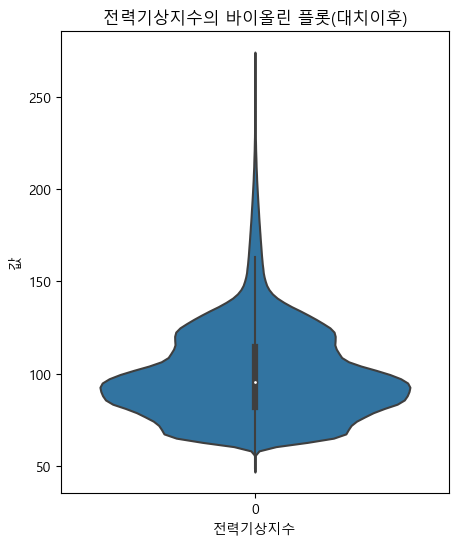

In [18]:
yNew=train['electric_train.elec']
plt.figure(figsize=(5,6))
sns.violinplot(yNew)
plt.xlabel('전력기상지수')
plt.ylabel("값")
plt.title("전력기상지수의 바이올린 플롯(대치이후)")
plt.savefig(path+"전력기상지수_바이올린플롯(대치이후).png")
plt.show()

del yNew

## 전력부하량, 계약전력, 주택단지수 관계

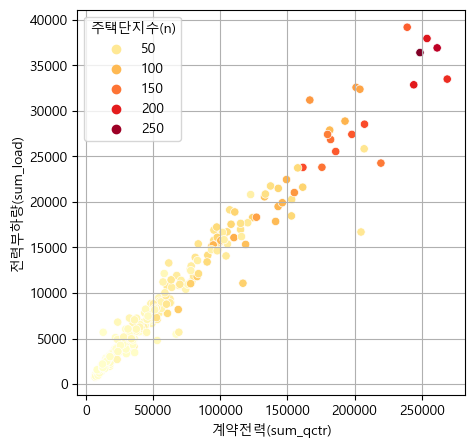

In [19]:
sampleDf=train.groupby("electric_train.num")[['electric_train.n','electric_train.sum_qctr','electric_train.sum_load']].mean().reset_index()
sampleDf['electric_train.n'] = sampleDf['electric_train.n'].apply(lambda x: round(x))
sampleDf.rename(columns={"electric_train.n":"주택단지수(n)"}, inplace=True)
plt.figure(figsize=(5,5))
sns.scatterplot(data=sampleDf, x="electric_train.sum_qctr", y="electric_train.sum_load", hue="주택단지수(n)", palette="YlOrRd")
plt.grid(True)
plt.xlabel("계약전력(sum_qctr)")
plt.ylabel("전력부하량(sum_load)")
plt.savefig("./시각화/전력공간관계.png")
plt.show()

In [68]:
print("평균 전력부하량이 가장 높은 격자 확인")
print(train.groupby("electric_train.num")['electric_train.sum_load'].mean().idxmax())
print()
print("평균 전력부하량이 가장 낮은 격자 확인")
print(train.groupby("electric_train.num")['electric_train.sum_load'].mean().idxmin())

평균 전력부하량이 가장 높은 격자 확인
18984

평균 전력부하량이 가장 낮은 격자 확인
4821


## 기상변수

In [20]:
weatherCols=['electric_train.nph_ta','electric_train.nph_hm','electric_train.nph_ws_10m','electric_train.nph_rn_60m','electric_train.nph_ta_chi']
train[weatherCols]

,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi
0,2.2,62.7,1.8,0.0,-1.0
1,2.3,63.1,2.1,0.0,-0.6
2,2.2,62.4,2.5,0.0,-1.3
3,1.7,63.5,1.7,0.0,-0.2
4,1.7,63.0,1.6,0.0,-0.8
...,...,...,...,...,...
7593350,2.7,46.3,3.1,0.0,-0.4
7593351,2.6,46.8,3.1,0.0,-0.5
7593352,2.4,47.4,2.1,0.0,0.2
7593353,2.5,47.0,2.1,0.0,0.3


In [21]:
print("기술통계량 확인")
display(train[weatherCols].describe().apply(lambda x: round(x,3)))

기술통계량 확인


,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi
count,7593355.000,7593355.000,7593355.000,7593355.000,7593355.000
mean,14.118,69.971,1.913,0.116,13.759
std,8.941,20.539,1.755,0.999,11.433
min,-24.600,2.700,-99.000,0.000,-26.700
25%,7.400,56.000,0.700,0.000,4.700
50%,14.800,72.900,1.500,0.000,14.800
75%,21.500,87.400,2.700,0.000,23.700
max,36.900,100.000,27.400,102.200,37.400


바이올린 플롯 확인


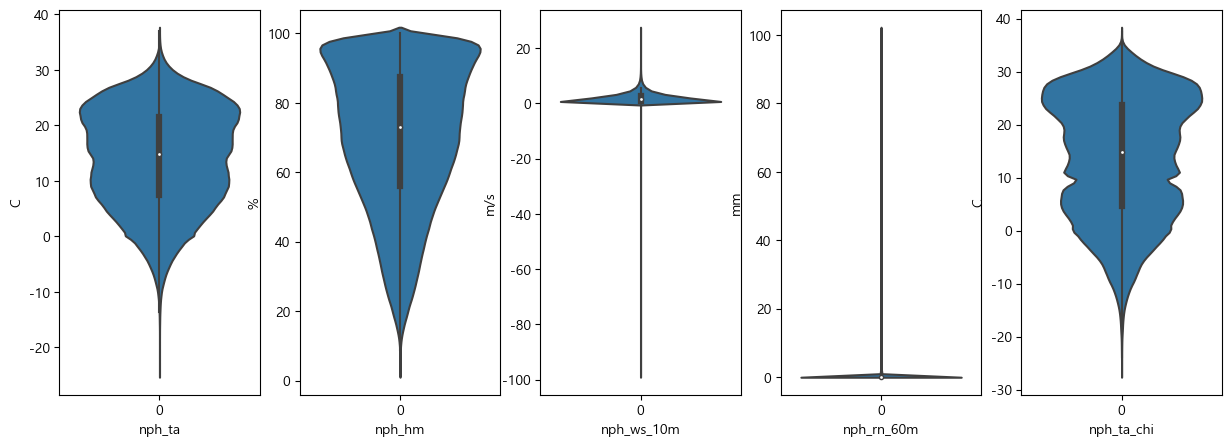

In [22]:
print("바이올린 플롯 확인")
fig, ax =plt.subplots(1,5,figsize=(15,5))
unit =["C","%","m/s","mm","C"]
for i,w in enumerate(weatherCols):
    sns.violinplot(train[w], ax=ax[i])
    ax[i].set_xlabel(w.replace("electric_train.",""))
    ax[i].set_ylabel(unit[i])
plt.show()
del fig, ax, unit

### 바람 결측치 대치

In [23]:
# 바람 결측치 확인
print(train.replace(-99,None).isna().sum())
train.replace(-99, None, inplace=True)
naIndex= train[train['electric_train.nph_ws_10m'].isna()].index
train.loc[naIndex]
# 전일과 후일의 평균으로 대체
imputeCol = (train['electric_train.nph_ws_10m'].fillna(method='ffill') + train['electric_train.nph_ws_10m'].fillna(method='bfill')) / 2
train['electric_train.nph_ws_10m'].fillna(imputeCol, inplace=True)
del naIndex, imputeCol

electric_train.num              0
electric_train.tm               0
electric_train.hh24             0
electric_train.n                0
electric_train.stn              0
electric_train.sum_qctr         0
electric_train.sum_load         0
electric_train.n_mean_load      0
electric_train.nph_ta           0
electric_train.nph_hm           0
electric_train.nph_ws_10m     169
electric_train.nph_rn_60m       0
electric_train.nph_ta_chi       0
electric_train.weekday          0
electric_train.week_name        0
electric_train.elec             0
dtype: int64


바이올린 플롯 확인(바람 결측치 대치 이후)


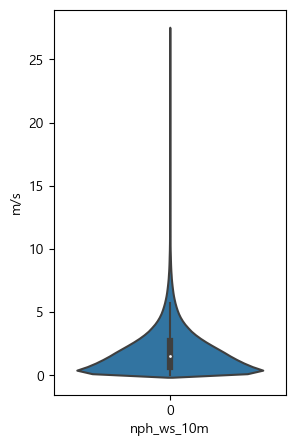

In [24]:
print("바이올린 플롯 확인(바람 결측치 대치 이후)")
plt.figure(figsize=(3,5))
sns.violinplot(train['electric_train.nph_ws_10m'])
plt.xlabel("nph_ws_10m")
plt.ylabel("m/s")
plt.show()

### 체감온도 심층분석

체감온도와 전력부하량, 계절 상관성(샘플 1% 추출)


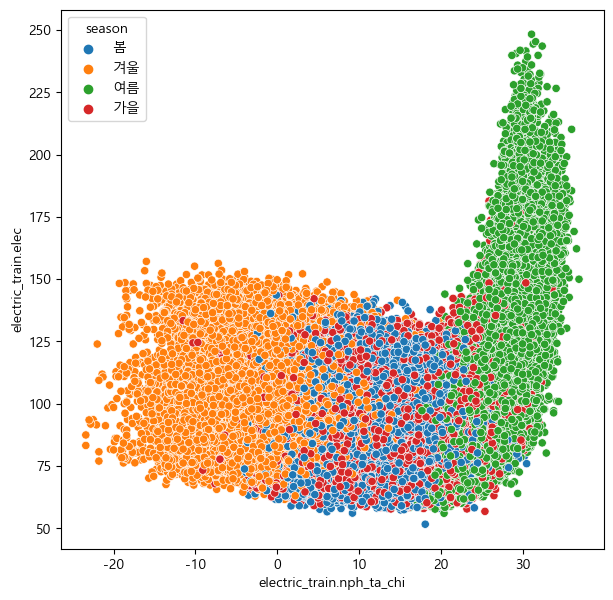

In [25]:
sampleDf = train[['electric_train.nph_ta_chi','electric_train.elec','electric_train.tm']].sample(frac=0.01)
sampleDf['month']=pd.to_datetime(train['electric_train.tm']).apply(lambda x: getattr(x,'month'))
def getSeason(m):
    if m<=2:
        return "겨울"
    elif m<=5:
        return "봄"
    elif m<=8:
        return "여름"
    elif m<=11:
        return "가을"
    else:
        return "겨울"
sampleDf["season"]=sampleDf['month'].apply(lambda x: getSeason(x))
print("체감온도와 전력부하량, 계절 상관성(샘플 1% 추출)")
plt.figure(figsize=(7,7))
sns.scatterplot(data=sampleDf, x="electric_train.nph_ta_chi", y="electric_train.elec", hue="season")
plt.show()
del getSeason
# 임의로 월에 따라 계절을 나누면, 노이즈를 발생시킬 수 있어 위험하다.

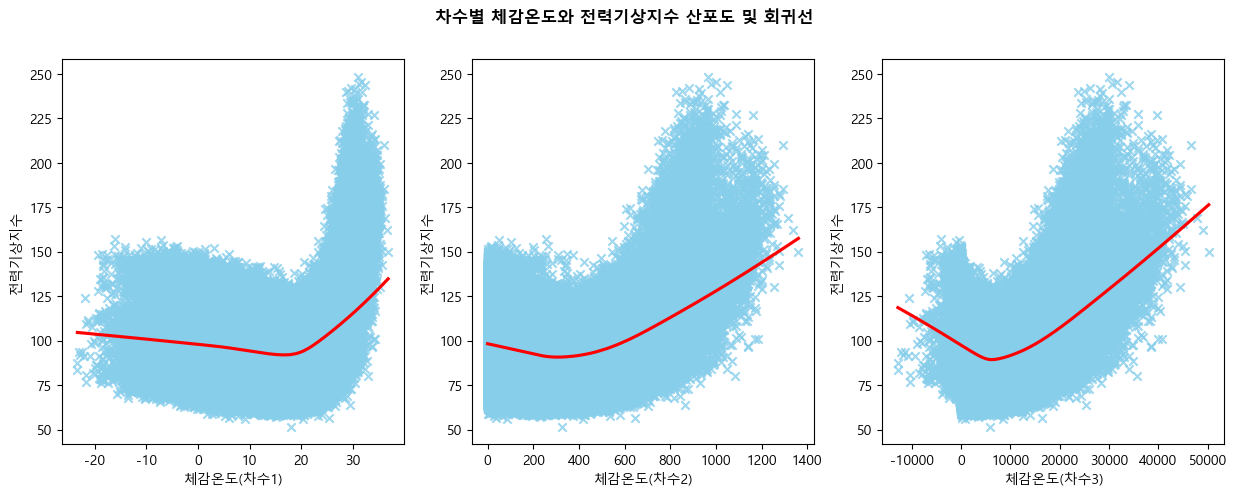

In [26]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(ax.shape[0]):
    sns.regplot(x=sampleDf['electric_train.nph_ta_chi']**(i+1), y=sampleDf['electric_train.elec'], ax=ax[i], marker="x", lowess=True
                , line_kws={"color": "red"}, scatter_kws={"color":"skyblue"})
    ax[i].set_xlabel(f"체감온도(차수{i+1})")
    ax[i].set_ylabel("전력기상지수")
fig.suptitle("차수별 체감온도와 전력기상지수 산포도 및 회귀선",fontweight ="bold")
plt.savefig("./시각화/체감온도차수_전력기상지수_회귀산포도.png")
plt.show()

시간을 기준으로 차분을 하고자 전체 격자들의 평균 체감온도를 구함


,electric_train.tm,electric_train.nph_ta_chi
0,2020-01-01 01:00:00,-7.056000
1,2020-01-01 02:00:00,-6.949667
2,2020-01-01 03:00:00,-6.851667
3,2020-01-01 04:00:00,-6.541667
4,2020-01-01 05:00:00,-5.849333


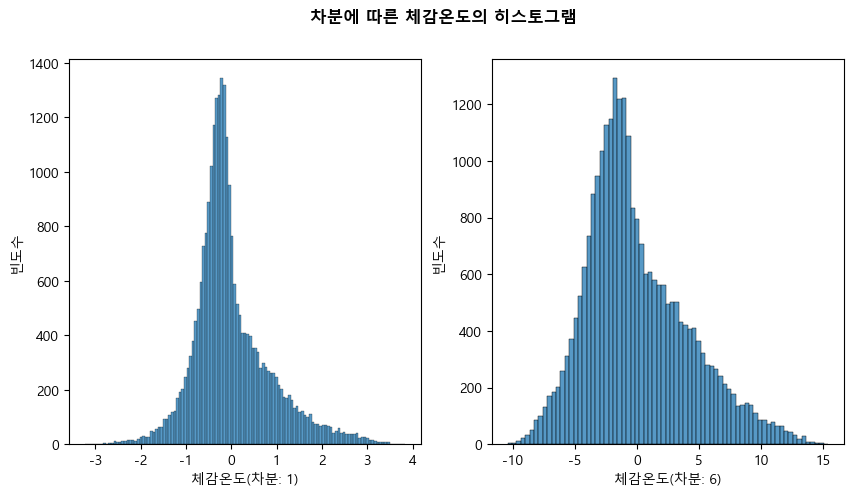

In [27]:
print("시간을 기준으로 차분을 하고자 전체 격자들의 평균 체감온도를 구함")
sampleDf=train.groupby("electric_train.tm")[['electric_train.nph_ta_chi']].mean().reset_index()
diffList=[1,6]
display(sampleDf.head())
fig, ax = plt.subplots(1,2,figsize=(10,5))
for i in range(ax.shape[0]):
    sns.histplot(sampleDf['electric_train.nph_ta_chi'].diff(diffList[i]), ax=ax[i])
    ax[i].set_xlabel(f"체감온도(차분: {diffList[i]})")
    ax[i].set_ylabel("빈도수")
fig.suptitle("차분에 따른 체감온도의 히스토그램", fontweight="bold")
plt.savefig("./시각화/체감온도차분_히스토그램.png")
plt.show()

In [28]:
train

,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
0,4821,2021-01-01 01:00:00,1,11,884,6950,751.32,68.606449,2.2,62.7,1.8,0.0,-1.0,4,0,99.56
1,4821,2021-01-01 02:00:00,2,11,884,6950,692.60,68.606449,2.3,63.1,2.1,0.0,-0.6,4,0,91.78
2,4821,2021-01-01 03:00:00,3,11,884,6950,597.48,68.606449,2.2,62.4,2.5,0.0,-1.3,4,0,79.17
3,4821,2021-01-01 04:00:00,4,11,884,6950,553.48,68.606449,1.7,63.5,1.7,0.0,-0.2,4,0,73.34
4,4821,2021-01-01 05:00:00,5,11,884,6950,526.24,68.606449,1.7,63.0,1.6,0.0,-0.8,4,0,69.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7593350,20947,2022-12-31 20:00:00,20,23,671,34200,6779.84,225.461986,2.7,46.3,3.1,0.0,-0.4,5,1,130.74
7593351,20947,2022-12-31 21:00:00,21,23,671,34200,6802.40,225.461986,2.6,46.8,3.1,0.0,-0.5,5,1,131.18
7593352,20947,2022-12-31 22:00:00,22,23,671,34200,6706.68,225.461986,2.4,47.4,2.1,0.0,0.2,5,1,129.33
7593353,20947,2022-12-31 23:00:00,23,23,671,34200,6355.88,225.461986,2.5,47.0,2.1,0.0,0.3,5,1,122.57


In [29]:
del sampleDf

## 제출데이터 확인

In [30]:
display(submit.describe().apply(lambda x: round(x,3)))

,NUM,HH24,STN,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elect
count,2829478.000,2829478.000,2829478.000,2829478.000,2829478.000,2829478.000,2829478.000,2829478.000,2829478.000,2829478.000,0.0
mean,15290.872,12.500,483.628,14.649,71.616,1.825,0.152,14.426,3.008,0.288,NaN
std,3380.101,6.922,260.223,9.182,20.359,1.643,1.125,11.662,2.003,0.453,NaN
min,4816.000,1.000,98.000,-20.700,5.400,0.000,0.000,-26.500,0.000,0.000,NaN
25%,12322.000,6.250,257.000,7.700,57.800,0.600,0.000,4.800,1.000,0.000,NaN
50%,15862.000,12.500,444.000,15.500,75.200,1.400,0.000,15.600,3.000,0.000,NaN
75%,18387.000,18.750,671.000,22.300,89.100,2.500,0.000,24.800,5.000,1.000,NaN
max,20947.000,24.000,991.000,36.300,106.500,20.900,190.500,37.300,6.000,1.000,NaN


# 저장: electric_train1.csv
- 이상치와 결측치가 처리된 데이터

In [31]:
train.to_csv("electric_train1.csv",index=False)

# 특성공학 전처리

In [4]:
train=pd.read_csv("electric_train1.csv")
print("결측치 및 이상치 대체된 훈련데이터 로드 완료")
submit=pd.read_csv("electric_test.csv")
print("제출용 데이터 로드 완료")

결측치 및 이상치 대체된 훈련데이터 로드 완료
제출용 데이터 로드 완료


In [33]:
display(train.head())
display(submit.head())

,electric_train.num,electric_train.tm,electric_train.hh24,electric_train.n,electric_train.stn,electric_train.sum_qctr,electric_train.sum_load,electric_train.n_mean_load,electric_train.nph_ta,electric_train.nph_hm,electric_train.nph_ws_10m,electric_train.nph_rn_60m,electric_train.nph_ta_chi,electric_train.weekday,electric_train.week_name,electric_train.elec
0,4821,2021-01-01 01:00:00,1,11,884,6950,751.32,68.606449,2.2,62.7,1.8,0.0,-1.0,4,0,99.56
1,4821,2021-01-01 02:00:00,2,11,884,6950,692.60,68.606449,2.3,63.1,2.1,0.0,-0.6,4,0,91.78
2,4821,2021-01-01 03:00:00,3,11,884,6950,597.48,68.606449,2.2,62.4,2.5,0.0,-1.3,4,0,79.17
3,4821,2021-01-01 04:00:00,4,11,884,6950,553.48,68.606449,1.7,63.5,1.7,0.0,-0.2,4,0,73.34
4,4821,2021-01-01 05:00:00,5,11,884,6950,526.24,68.606449,1.7,63.0,1.6,0.0,-0.8,4,0,69.73


,NUM,TM,HH24,STN,nph_ta,nph_hm,nph_ws_10m,nph_rn_60m,nph_ta_chi,weekday,week_name,elect
0,4816,2023-01-01 01:00:00,1,752,3.0,68.6,2.9,0.0,-0.1,6,1.0,NaN
1,4816,2023-01-01 02:00:00,2,752,3.1,69.4,2.7,0.0,0.3,6,1.0,NaN
2,4816,2023-01-01 03:00:00,3,752,3.6,68.3,2.3,0.0,1.2,6,1.0,NaN
3,4816,2023-01-01 04:00:00,4,752,4.0,69.2,3.1,0.0,1.1,6,1.0,NaN
4,4816,2023-01-01 05:00:00,5,752,4.2,69.5,2.5,0.0,2.0,6,1.0,NaN


## 전처리 클래스

In [5]:
class prepareData:
    """feature engineering"""
    def __init__(self, train, submit):
        self.train=train.copy()
        self.submit=submit.copy()
        self.rankMapping={}
        self.evr=None

    
    def extractWeatherPC(self):
        """기온, 습도, 풍속, 강수량을 주성분 추출하여 특성의 수를 줄이고 기상변수들의 조합 변수로 변환"""
        trainWeathers = ['electric_train.nph_ta','electric_train.nph_hm','electric_train.nph_ws_10m','electric_train.nph_rn_60m']
        submitWeathers = [w.replace("electric_train.","") for w in trainWeathers]
        
        train_weahterDf = self.train[trainWeathers]
        submit_weahterDf = self.submit[submitWeathers]

        from sklearn.preprocessing import MinMaxScaler
        scaler=MinMaxScaler()
        train_weatherVl = scaler.fit_transform(train_weahterDf.values)
        submit_weatherVl = scaler.transform(submit_weahterDf.values)

        from sklearn.decomposition import PCA
        pca=PCA()
        pca.fit(train_weatherVl)
        evr = 0
        nCols=0
        for i, v in enumerate(pca.explained_variance_ratio_):
            if evr>=0.9:
                break
            evr+=v
            nCols=i+1
        self.evr=evr
        trainPC=pca.transform(train_weatherVl)
        submitPC=pca.transform(submit_weatherVl)
        
        for n in range(nCols):
            self.train[f"weatherPC{n}"]=trainPC[:,n]
            self.submit[f"weatherPC{n}"]=submitPC[:,n]

        self.train.drop(trainWeathers,axis=1, inplace=True)
        self.submit.drop(submitWeathers,axis=1, inplace=True)
    
    def createPolyTaChi(self,polys=[2,3]):
        """p: 다항 차수, 체감온도의 비선형 구조를 만들어주고자 2차항 및 3차항을 다항 특성으로 만들어준다"""
        for p in polys:
            self.train[f'electric_train.nph_ta_chi_poly{p}'] = self.train['electric_train.nph_ta_chi'].apply(lambda x: x**p)
            self.submit[f'nph_ta_chi_poly{p}'] = self.submit['nph_ta_chi'].apply(lambda x: x**p)
    
    def createDiffTaChi(self, diffHour=[-1,1]):
        """t=[차분 차수], 차분차수<0: 미래적,장기적 체감온도 고려. 차분차수>0: 회귀적,경험적 체감온도 고려. 기상 컬럼 중 가장 예측 중요도가 높았던 체감온도"""
        
        trainNumList=self.train['electric_train.num'].unique()
        for d in diffHour:
            self.train[f'electric_train.nph_ta_chi_diff{d}']= None
            for n in trainNumList:
                numIndex = self.train[self.train['electric_train.num']==n].index
                self.train.loc[numIndex,f'electric_train.nph_ta_chi_diff{d}'] = self.train.loc[numIndex,'electric_train.nph_ta_chi'].diff(d).fillna(0)
                
        submitNumList=self.submit['NUM'].unique()
        for d in diffHour:
            self.submit[f'nph_ta_chi_diff{d}']= None
            for n in submitNumList:
                numIndex = self.submit[self.submit['NUM']==n].index
                self.submit.loc[numIndex,f'nph_ta_chi_diff{d}'] = self.submit.loc[numIndex,'nph_ta_chi'].diff(d).fillna(0)
    
    def createTimeFeatures(self):
        """tm에서 시계열 정보를 추출하는 함수"""
        timeFeat=['year','month','day','hour','dayofyear'] # dayofyear 추가
        for t in timeFeat:
            self.train[t]=pd.to_datetime(self.train['electric_train.tm']).apply(lambda x: getattr(x, t))
            self.submit[t]=pd.to_datetime(self.submit['TM']).apply(lambda x: getattr(x, t))
        self.train['isSummer'] = self.train['month'].apply(lambda x: 1 if ((x==7)|(x==8)) else 0 )
        self.submit['isSummer'] = self.submit['month'].apply(lambda x: 1 if ((x==7)|(x==8)) else 0 )


    def rankFeatures(self):
        "월, 일, 시간, 요일별로 순위를 매겨 값을 순위값으로 대체하여 높을 수록 높은 값을 갖도록 하는 함수"
        self.rankMapping['month']=self.train.groupby('month')['electric_train.sum_load'].mean().rank().to_dict()
        self.rankMapping['day']=self.train.groupby('day')['electric_train.sum_load'].mean().rank().to_dict()
        self.rankMapping['hour']=self.train.groupby('hour')['electric_train.sum_load'].mean().rank().to_dict()
        self.rankMapping['weekday']=self.train.groupby('electric_train.weekday')['electric_train.sum_load'].mean().rank().to_dict()

        self.train['month'] = self.train['month'].apply(lambda x: self.rankMapping['month'][x])
        self.submit['month'] = self.submit['month'].apply(lambda x: self.rankMapping['month'][x])
        self.train['day'] = self.train['day'].apply(lambda x: self.rankMapping['day'][x])
        self.submit['day'] = self.submit['day'].apply(lambda x: self.rankMapping['day'][x])
        self.train['hour'] = self.train['hour'].apply(lambda x: self.rankMapping['hour'][x])
        self.submit['hour'] = self.submit['hour'].apply(lambda x: self.rankMapping['hour'][x])
        self.train['electric_train.weekday'] = self.train['electric_train.weekday'].apply(lambda x: self.rankMapping['weekday'][x])
        self.submit['weekday'] = self.submit['weekday'].apply(lambda x: self.rankMapping['weekday'][x])

    def clearCols(self, dropCols=["n","sum_qctr","sum_load","n_mean_load"]):
        """훈련데이터의 불필요한 접미사 제거 및 훈련데이터에서 예측에 불필요한(검증용 데이터에서 제공되지 않는 정보들) 컬럼들 제거"""
        self.train.columns = [ col.replace("electric_train.","") if "electric_train." in col else col for col in self.train.columns]
        self.train.drop(dropCols,axis=1, inplace=True)
        # 중복된 시간 컬럼 제거
        self.train.drop("hh24", axis=1, inplace=True)
        self.submit.drop("HH24", axis=1, inplace=True)

    def getTrain(self):
        return self.train

    def getSubmit(self):
        return self.submit



In [6]:
prepare=prepareData(train, submit)
prepare.extractWeatherPC()
prepare.createPolyTaChi()
prepare.createDiffTaChi(diffHour=[-6,-5,-4,-3,-2,-1,1,2,3,4,5,6])
prepare.createTimeFeatures()
prepare.rankFeatures()
prepare.clearCols()
train, submit = prepare.getTrain(), prepare.getSubmit()


In [36]:
print("훈련데이터 컬럼명: ",train.columns)
print("훈련데이터 shape: ",train.shape)
print()
print("제출데이터 컬럼명: ",submit.columns)
print("제출데이터 shape: ",submit.shape)
print()
print("컬럼 순서 동일한지 확인(elec 과 elect만 다르면 됨)")
for tr,sb in zip(train.columns, submit.columns):
    if tr.lower()==sb.lower():
        print(tr.lower()==sb.lower(), end=", ")
    else:
        print("다른 컬럼: ", tr, sb, end=", ")

print("",end="\n\n")
print("기상컬럼 차원축소(체감온도 제외) 주성분 분산 설명력: ", round(prepare.evr*100,2), "%", end="\n\n")
print("순위화된 시간 데이터 매핑 정보: ")
print(prepare.rankMapping)

훈련데이터 컬럼명:  Index(['num', 'tm', 'stn', 'nph_ta_chi', 'weekday', 'week_name', 'elec',
       'weatherPC0', 'weatherPC1', 'nph_ta_chi_poly2', 'nph_ta_chi_poly3',
       'nph_ta_chi_diff-6', 'nph_ta_chi_diff-5', 'nph_ta_chi_diff-4',
       'nph_ta_chi_diff-3', 'nph_ta_chi_diff-2', 'nph_ta_chi_diff-1',
       'nph_ta_chi_diff1', 'nph_ta_chi_diff2', 'nph_ta_chi_diff3',
       'nph_ta_chi_diff4', 'nph_ta_chi_diff5', 'nph_ta_chi_diff6', 'year',
       'month', 'day', 'hour', 'dayofyear', 'isSummer'],
      dtype='object')
훈련데이터 shape:  (7593355, 29)

제출데이터 컬럼명:  Index(['NUM', 'TM', 'STN', 'nph_ta_chi', 'weekday', 'week_name', 'elect',
       'weatherPC0', 'weatherPC1', 'nph_ta_chi_poly2', 'nph_ta_chi_poly3',
       'nph_ta_chi_diff-6', 'nph_ta_chi_diff-5', 'nph_ta_chi_diff-4',
       'nph_ta_chi_diff-3', 'nph_ta_chi_diff-2', 'nph_ta_chi_diff-1',
       'nph_ta_chi_diff1', 'nph_ta_chi_diff2', 'nph_ta_chi_diff3',
       'nph_ta_chi_diff4', 'nph_ta_chi_diff5', 'nph_ta_chi_diff6', 'year',
       

## 스케일링 클래스

In [7]:
class transformData:
    """train, test, features를 입력받아 모델링에 적합한 X_train, y_train, submit로 변환 및 반환하는 함수"""
    def __init__(self, train, submit, scaler):
        self.X_train=train.drop('elec', axis=1)
        self.y_train=train['elec'] 
        self.submit= submit.copy()
        self.scaler=scaler
    def selectFeatures(self, trainFeatures, submitFeatures):
        self.X_train=self.X_train[trainFeatures]
        self.submit = self.submit[submitFeatures]
    
    def scaleData(self):
        self.X_train=self.scaler.fit_transform(self.X_train.values)
        self.submit=self.scaler.transform(self.submit.values)

    def getTrainData(self):
        return self.X_train, self.y_train
        
    def getSubmitData(self):
        return self.submit

In [38]:
print("모델링 결과 변수 중요도가 낮았거나 노이즈로 작용할 수 있는 불필요한 변수 제거")
print("변수 중요도 낮았던 변수: isSummer, week_name, nph_ta_chi_poly3")
print("노이즈 가능성 있는 변수: tm, year, day")
print("종속변수: elec, elect")
print()

print("스케일링 진행")
trainFeatures=train.columns.drop(['tm','year','day','elec','isSummer', 'week_name', 'nph_ta_chi_poly3'])
submitFeatures=submit.columns.drop(['TM','year','day','elect','isSummer', 'week_name', 'nph_ta_chi_poly3' ])
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
transform=transformData(train,submit,scaler)
transform.selectFeatures(trainFeatures,submitFeatures)
transform.scaleData()
X_train, y_train = transform.getTrainData()
submitData = transform.getSubmitData()
print()

print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("submitData shape",submitData.shape)
print("사용 컬럼: ",submitFeatures)

모델링 결과 변수 중요도가 낮았거나 노이즈로 작용할 수 있는 불필요한 변수 제거
변수 중요도 낮았던 변수: isSummer, week_name, nph_ta_chi_poly3
노이즈 가능성 있는 변수: tm, year, day
종속변수: elec, elect

스케일링 진행

X_train shape:  (7593355, 22)
y_train shape:  (7593355,)
submitData shape (2829478, 22)
사용 컬럼:  Index(['NUM', 'STN', 'nph_ta_chi', 'weekday', 'weatherPC0', 'weatherPC1',
       'nph_ta_chi_poly2', 'nph_ta_chi_diff-6', 'nph_ta_chi_diff-5',
       'nph_ta_chi_diff-4', 'nph_ta_chi_diff-3', 'nph_ta_chi_diff-2',
       'nph_ta_chi_diff-1', 'nph_ta_chi_diff1', 'nph_ta_chi_diff2',
       'nph_ta_chi_diff3', 'nph_ta_chi_diff4', 'nph_ta_chi_diff5',
       'nph_ta_chi_diff6', 'month', 'hour', 'dayofyear'],
      dtype='object')


In [39]:
del prepare, transform

# 모델링

## 모델 탐색
- 모델링기록.ipynb 에서 수행함.

## 최종 모델 적용

In [40]:
print("가장 성능 우수했던 모델 불러오기")
with open("./모델링기록/0622_2/lgbm_model.pkl",'rb') as f:
    model = pickle.load(f)
print(model)
print("모델링 과정을 보고자 verbos만 1로 변경")
params=model.get_params()
params['verbose']=1
model.set_params(**params)
print("모델의 파라미터 확인")
print(model.get_params())

가장 성능 우수했던 모델 불러오기
LGBMRegressor(colsample_bytree=0.9, learning_rate=0.05, metric='mae',
              min_child_samples=1, min_split_gain=0.0003, n_estimators=2262,
              num_leaves=180, random_state=41, reg_alpha=7.67, reg_lambda=0.85,
              subsample_for_bin=223917, verbose=0)
모델링 과정을 보고자 verbos만 1로 변경
모델의 파라미터 확인
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.9, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 1, 'min_child_weight': 0.001, 'min_split_gain': 0.0003, 'n_estimators': 2262, 'n_jobs': None, 'num_leaves': 180, 'objective': None, 'random_state': 41, 'reg_alpha': 7.67, 'reg_lambda': 0.85, 'subsample': 1.0, 'subsample_for_bin': 223917, 'subsample_freq': 0, 'metric': 'mae', 'verbose': 1}


In [41]:
print("모델 교차검증(3회)")

from sklearn.model_selection import cross_validate, KFold
cvResult= cross_validate(estimator=model, X=X_train, y=y_train, cv=KFold(n_splits=3, shuffle=True, random_state=23), scoring=['r2','neg_mean_absolute_error'], verbose=1)


모델 교차검증(3회)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4242
[LightGBM] [Info] Number of data points in the train set: 5062236, number of used features: 22
[LightGBM] [Info] Start training from score 99.991976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.317432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4274
[LightGBM] [Info] Number of data points in the train set: 5062237, number of used features: 22
[LightGBM] [Info] Start training from score 100.005239
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.292617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4259
[LightGBM] [Info] Number of data points in the tr

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 30.0min finished


In [44]:
print("교차검증 결과 확인")
print("3회 평균 훈련 시간: ", np.round(np.mean(cvResult['fit_time']),2), "초")
print("3회 R스퀘어 점수: ", np.round(cvResult['test_r2'],3))
print("평균 R스퀘어 점수: ", np.round(np.mean(cvResult['test_r2']),3))
print("3회 평균절대오차 점수: ", np.abs(np.round(cvResult['test_neg_mean_absolute_error'],3)))
print("평균 평균절대오차 점수: ", np.abs(np.round(np.mean(cvResult['test_neg_mean_absolute_error']),3)))

# del cvResult

교차검증 결과 확인
3회 평균 훈련 시간:  371.27 초
3회 R스퀘어 점수:  [0.985 0.985 0.985]
평균 R스퀘어 점수:  0.985
3회 평균절대오차 점수:  [2.187 2.184 2.189]
평균 평균절대오차 점수:  2.187


In [46]:
print("전체 훈련데이터를 사용하여 훈련")
import datetime
start = datetime.datetime.now()
model.fit(X_train,y_train)
print("훈련완료. 걸린 시간: ", datetime.datetime.now()-start)

del start

전체 훈련데이터를 사용하여 훈련
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.460697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4274
[LightGBM] [Info] Number of data points in the train set: 7593355, number of used features: 22
[LightGBM] [Info] Start training from score 99.999683
훈련완료. 걸린 시간:  0:09:26.877678


In [47]:
print("예측 수행")
pred=model.predict(submitData)
test=pd.read_csv('electric_test.csv')
test['elect']=np.round(pred,4)
test.to_csv("240169.csv",index=False)
print("예측 및 저장 완료")

예측 수행
예측 및 저장 완료


In [48]:
with open("lgbm_model.pkl", 'wb') as f:
    pickle.dump(model,f)
print("모델 저장 완료")

모델 저장 완료


# 결과 확인 및 해석

In [8]:
pred= pd.read_csv("240169.csv")['elect']

## 특성 중요도

피쳐 중요도 확인
수치 확인
dayofyear            70901
NUM                  69507
STN                  35502
hour                 34959
weekday              32335
nph_ta_chi           31086
nph_ta_chi_diff6     17047
weatherPC0           16374
weatherPC1           14115
nph_ta_chi_diff-6    13438
nph_ta_chi_poly2      9521
month                 8709
nph_ta_chi_diff5      7225
nph_ta_chi_diff-5     6300
nph_ta_chi_diff2      5464
nph_ta_chi_diff4      5370
nph_ta_chi_diff3      5233
nph_ta_chi_diff-4     5131
nph_ta_chi_diff-3     4844
nph_ta_chi_diff-2     4713
nph_ta_chi_diff1      4084
nph_ta_chi_diff-1     3040
dtype: int32
****************************************************************************************************
시각화 확인


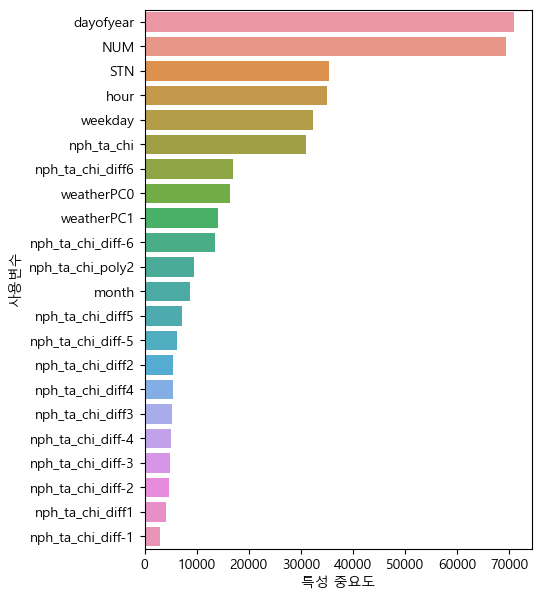

In [49]:
print("피쳐 중요도 확인")
featSr = pd.Series(model.feature_importances_, index= submitFeatures).sort_values(ascending=False)
print("수치 확인")
print(featSr)
print("*"*100)
print("시각화 확인")
plt.figure(figsize=(5,7))
sns.barplot(x=featSr.values, y=featSr.index)
plt.xlabel("특성 중요도")
plt.ylabel("사용변수")
plt.savefig("./시각화/특성중요도.png")
plt.show()

del featSr

## 예측값의 히스토그램

훈련 데이터의 전력기상지수와 예측 전력기상지수 비교


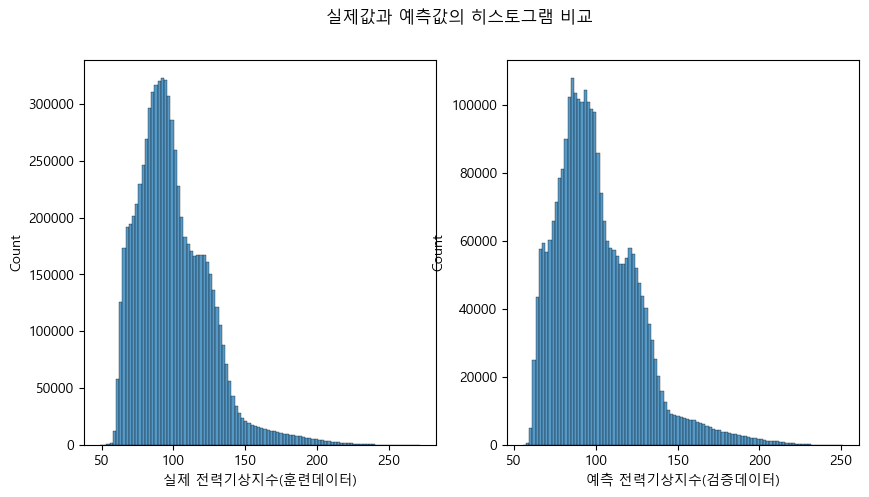

In [59]:
print("훈련 데이터의 전력기상지수와 예측 전력기상지수 비교")
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.histplot(y_train, ax=ax[0],bins=100)
ax[0].set_xlabel("실제 전력기상지수(훈련데이터)")

sns.histplot(np.round(pred,2), ax=ax[1],bins=100)
ax[1].set_xlabel("예측 전력기상지수(검증데이터)")

fig.suptitle("실제값과 예측값의 히스토그램 비교")
plt.savefig("./시각화/실제예측_히스토비교.png")
plt.show()

In [97]:
[ datetime.datetime(2023,6,int(idx.split(" ")[0]), int(idx.split(" ")[1]),0,0) for idx in visData.index]
[ datetime.datetime(2023,6,int(idx.split(" ")[0]), int(idx.split(" ")[1]),0,0).strftime("%d %H") for idx in visData.index]

['25 00',
 '25 01',
 '25 02',
 '25 03',
 '25 04',
 '25 05',
 '25 06',
 '25 07',
 '25 08',
 '25 09',
 '25 10',
 '25 11',
 '25 12',
 '25 13',
 '25 14',
 '25 15',
 '25 16',
 '25 17',
 '25 18',
 '25 19',
 '25 20',
 '25 21',
 '25 22',
 '25 23',
 '26 00',
 '26 01',
 '26 02',
 '26 03',
 '26 04',
 '26 05',
 '26 06',
 '26 07',
 '26 08',
 '26 09',
 '26 10',
 '26 11',
 '26 12',
 '26 13',
 '26 14',
 '26 15',
 '26 16',
 '26 17',
 '26 18',
 '26 19',
 '26 20',
 '26 21',
 '26 22',
 '26 23',
 '27 00']

## 시계열 전력기상지수와 체감온도

In [ ]:
import warnings
warnings.filterwarnings('ignore')
print("NUM별 2023년 6월 25일 ~ 27일 전력기상 지수와 체감온도 그래프 그려보기",end="\n\n")
numValues = submit['NUM'].unique()
# numValues = []

## 날짜 설정
month = 7
day_start = 24
day_end = day_start + 3

submit['elect']= pred
submit['TM'] = pd.to_datetime(submit['TM'])
print(submit.columns)

tmCond1 = submit['TM'] >= datetime.datetime(2023,month,day_start) 
tmCond2 = submit['TM'] <= datetime.datetime(2023,month,day_end) 
tmDf = submit[tmCond1&tmCond2]

for n in range(len(numValues)):
    numCond = tmDf['NUM'] == numValues[n]
    numDf= tmDf[numCond]
    visDf=numDf[['TM','elect','nph_ta_chi']]
    visDf['TM'] = pd.to_datetime(visDf['TM'])
    visDf['day_hour'] = visDf['TM'].map(lambda x: str(x)[8:13]) 
    visData = visDf.groupby('day_hour')[['elect','nph_ta_chi']].sum()
    
    fig, ax  = plt.subplots(figsize=(12,6))
    ax.plot(visData['elect'].values, color='blue', marker='o', label='전력기상지수', linewidth=3, markersize=6)
    ax.set_ylabel('전력기상지수', color='blue', fontsize=12, fontweight='bold')
    ax.axhline(100, color='blue', linestyle='--')
    
    ax_twin=ax.twinx()
    ax_twin.plot(visData['nph_ta_chi'].values, color='orange', marker='o', label="체감온도('C)", linewidth=3, markersize=6)
    ax_twin.set_ylabel('체감온도', color='orange', fontsize=12, fontweight='bold')
    ax_twin.axhline(29, color='orange', linestyle='--')
    # x축 눈금 설정
    # ax.set_xticks([ datetime.datetime(2023,6,int(idx.split(" ")[0]), int(idx.split(" ")[1]),0,0) for idx in visData.index])
    
    # 범례 표시
    ax.legend(loc='upper left')
    ax_twin.legend(loc='upper right')
    plt.grid(True)
    fig.suptitle(f"격자{numValues[n]}의 23년 {month}월 {day_start}일 ~ {day_end}일 시간대별 평균 전력기상지수와 체감온도", fontweight='bold', fontsize=18)
    plt.show()

전체격자 평균내어 전력기상 지수와 체감온도 그래프 그려보기

Index(['NUM', 'TM', 'STN', 'nph_ta_chi', 'weekday', 'week_name', 'elect',
       'weatherPC0', 'weatherPC1', 'nph_ta_chi_poly2', 'nph_ta_chi_poly3',
       'nph_ta_chi_diff-6', 'nph_ta_chi_diff-5', 'nph_ta_chi_diff-4',
       'nph_ta_chi_diff-3', 'nph_ta_chi_diff-2', 'nph_ta_chi_diff-1',
       'nph_ta_chi_diff1', 'nph_ta_chi_diff2', 'nph_ta_chi_diff3',
       'nph_ta_chi_diff4', 'nph_ta_chi_diff5', 'nph_ta_chi_diff6', 'year',
       'month', 'day', 'hour', 'dayofyear', 'isSummer'],
      dtype='object')


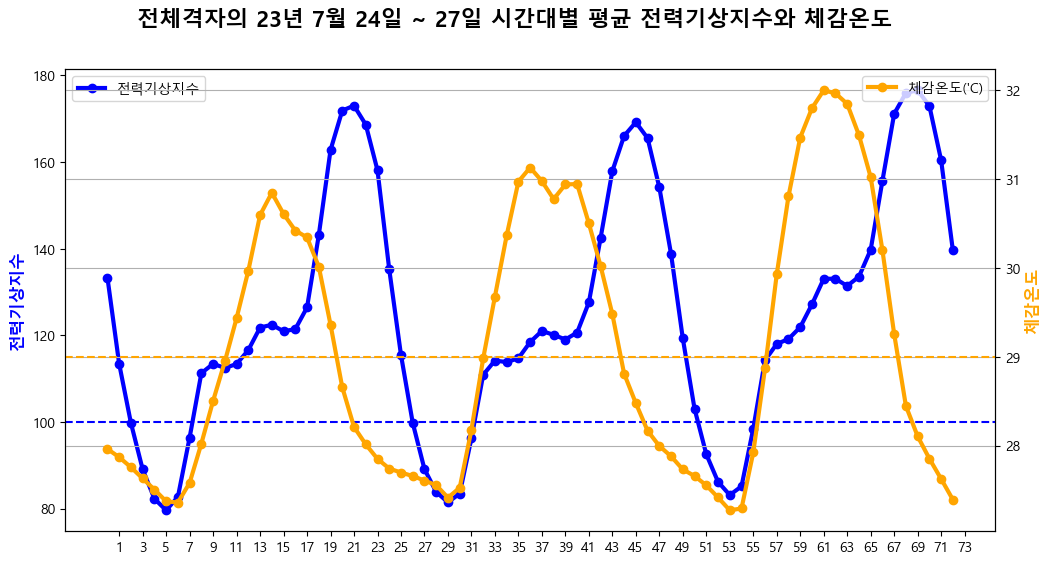

In [57]:
import warnings
warnings.filterwarnings('ignore')
print("전체격자 평균내어 전력기상 지수와 체감온도 그래프 그려보기",end="\n\n")
numValues = submit['NUM'].unique()

submit['elect']= pred
submit['TM'] = pd.to_datetime(submit['TM'])
print(submit.columns)

## 날짜 설정
month = 7
day_start = 24
day_end = day_start + 3

tmCond1 = submit['TM'] >= datetime.datetime(2023,month,day_start) 
tmCond2 = submit['TM'] <= datetime.datetime(2023,month,day_end) 
tmDf = submit[tmCond1&tmCond2]
visDf=tmDf[['TM','elect','nph_ta_chi']]
visDf['TM'] = pd.to_datetime(visDf['TM'])
visDf['day_hour'] = visDf['TM'].map(lambda x: str(x)[8:13]) 
visData = visDf.groupby('day_hour')[['elect','nph_ta_chi']].mean()

fig, ax  = plt.subplots(figsize=(12,6))
ax.plot(visData['elect'].values, color='blue', marker='o', label='전력기상지수', linewidth=3, markersize=6)
ax.set_ylabel('전력기상지수', color='blue', fontsize=12, fontweight='bold')
ax.axhline(100, color='blue', linestyle='--')
# ax.set_ylim([45,160])
# ax.set_yticks([45,60,75,90,105,120,135,150])

ax_twin=ax.twinx()
ax_twin.plot(visData['nph_ta_chi'].values, color='orange', marker='o', label="체감온도('C)", linewidth=3, markersize=6)
ax_twin.set_ylabel('체감온도', color='orange', fontsize=12, fontweight='bold')
ax_twin.axhline(29, color='orange', linestyle='--')
# x축 눈금 설정
ax.set_xticks([i for i in range(1,len(visData)+1,2)])

# 범례 표시
ax.legend(loc='upper left')
ax_twin.legend(loc='upper right')
fig.suptitle(f"전체격자의 23년 {month}월 {day_start}일 ~ {day_end}일 시간대별 평균 전력기상지수와 체감온도", fontweight='bold', fontsize=16)
plt.grid(True)
plt.show()

격자 18984 전력기상 지수와 체감온도 그래프 그려보기

격자 18984가 평균 전력부하량이 가장 높은 격자
Index(['NUM', 'TM', 'STN', 'nph_ta_chi', 'weekday', 'week_name', 'elect',
       'weatherPC0', 'weatherPC1', 'nph_ta_chi_poly2', 'nph_ta_chi_poly3',
       'nph_ta_chi_diff-6', 'nph_ta_chi_diff-5', 'nph_ta_chi_diff-4',
       'nph_ta_chi_diff-3', 'nph_ta_chi_diff-2', 'nph_ta_chi_diff-1',
       'nph_ta_chi_diff1', 'nph_ta_chi_diff2', 'nph_ta_chi_diff3',
       'nph_ta_chi_diff4', 'nph_ta_chi_diff5', 'nph_ta_chi_diff6', 'year',
       'month', 'day', 'hour', 'dayofyear', 'isSummer'],
      dtype='object')


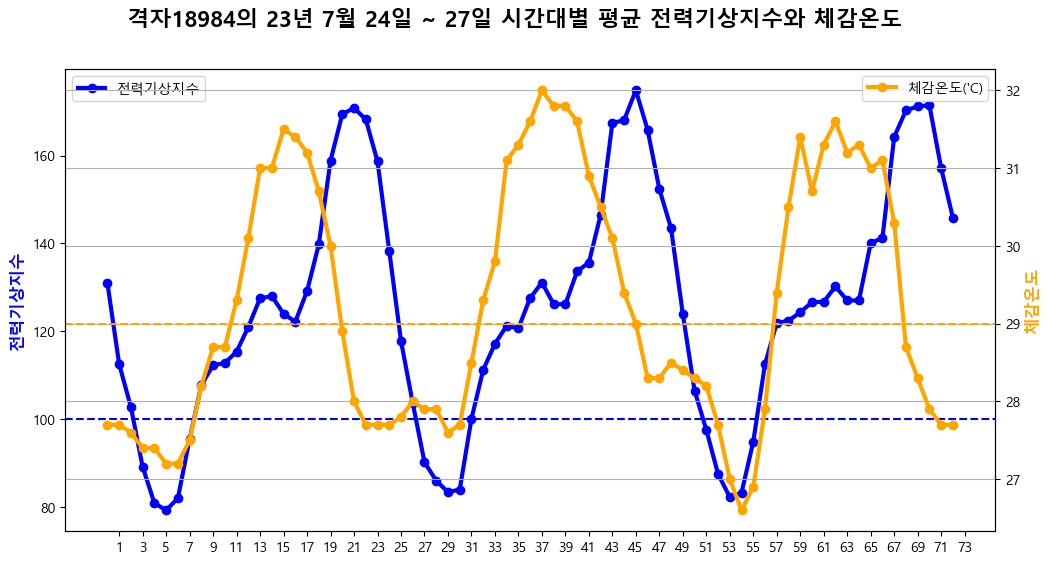

In [74]:
import warnings
warnings.filterwarnings('ignore')
print("격자 18984 전력기상 지수와 체감온도 그래프 그려보기",end="\n\n")
print("격자 18984가 평균 전력부하량이 가장 높은 격자")

submit['elect']= pred
submit['TM'] = pd.to_datetime(submit['TM'])
print(submit.columns)

## 날짜 설정
month = 7
day_start = 24
day_end = day_start + 3

# 격자설정
n=18984

tmCond1 = submit['TM'] >= datetime.datetime(2023,month,day_start) 
tmCond2 = submit['TM'] <= datetime.datetime(2023,month,day_end) 
tmDf = submit[tmCond1&tmCond2]

numCond = tmDf['NUM'] == n
numDf= tmDf[numCond]
visDf=numDf[['TM','elect','nph_ta_chi']]
visDf['TM'] = pd.to_datetime(visDf['TM'])
visDf['day_hour'] = visDf['TM'].map(lambda x: str(x)[8:13]) 
visData = visDf.groupby('day_hour')[['elect','nph_ta_chi']].mean()

fig, ax  = plt.subplots(figsize=(12,6))
ax.plot(visData['elect'].values, color='blue', marker='o', label='전력기상지수', linewidth=3, markersize=6)
ax.set_ylabel('전력기상지수', color='blue', fontsize=12, fontweight='bold')
ax.axhline(100, color='blue', linestyle='--')
# ax.set_ylim([45,160])
# ax.set_yticks([45,60,75,90,105,120,135,150])

ax_twin=ax.twinx()
ax_twin.plot(visData['nph_ta_chi'].values, color='orange', marker='o', label="체감온도('C)", linewidth=3, markersize=6)
ax_twin.set_ylabel('체감온도', color='orange', fontsize=12, fontweight='bold')
ax_twin.axhline(29, color='orange', linestyle='--')
# x축 눈금 설정
ax.set_xticks([i for i in range(1,len(visData)+1,2)])

# 범례 표시
ax.legend(loc='upper left')
ax_twin.legend(loc='upper right')
fig.suptitle(f"격자{n}의 23년 {month}월 {day_start}일 ~ {day_end}일 시간대별 평균 전력기상지수와 체감온도", fontweight='bold', fontsize=16)
plt.grid(True)
plt.savefig(f"격자{n}_전력기상지수와체감온도_시계열.png")
plt.show()

격자 4821 전력기상 지수와 체감온도 그래프 그려보기

격자 4821은 평균 전력부하량이 가장 낮은 격자
Index(['NUM', 'TM', 'STN', 'nph_ta_chi', 'weekday', 'week_name', 'elect',
       'weatherPC0', 'weatherPC1', 'nph_ta_chi_poly2', 'nph_ta_chi_poly3',
       'nph_ta_chi_diff-6', 'nph_ta_chi_diff-5', 'nph_ta_chi_diff-4',
       'nph_ta_chi_diff-3', 'nph_ta_chi_diff-2', 'nph_ta_chi_diff-1',
       'nph_ta_chi_diff1', 'nph_ta_chi_diff2', 'nph_ta_chi_diff3',
       'nph_ta_chi_diff4', 'nph_ta_chi_diff5', 'nph_ta_chi_diff6', 'year',
       'month', 'day', 'hour', 'dayofyear', 'isSummer'],
      dtype='object')


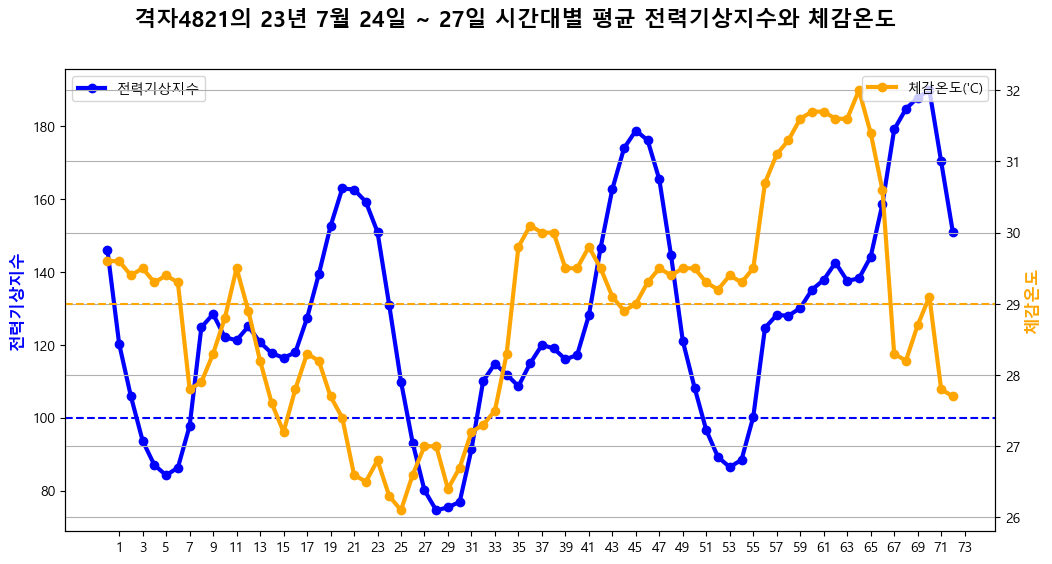

In [73]:
import warnings
warnings.filterwarnings('ignore')
print("격자 4821 전력기상 지수와 체감온도 그래프 그려보기",end="\n\n")
print("격자 4821은 평균 전력부하량이 가장 낮은 격자")

submit['elect']= pred
submit['TM'] = pd.to_datetime(submit['TM'])
print(submit.columns)

## 날짜 설정
month = 7
day_start = 24
day_end = day_start + 3

# 격자설정
n=4821

tmCond1 = submit['TM'] >= datetime.datetime(2023,month,day_start) 
tmCond2 = submit['TM'] <= datetime.datetime(2023,month,day_end) 
tmDf = submit[tmCond1&tmCond2]

numCond = tmDf['NUM'] == n
numDf= tmDf[numCond]
visDf=numDf[['TM','elect','nph_ta_chi']]
visDf['TM'] = pd.to_datetime(visDf['TM'])
visDf['day_hour'] = visDf['TM'].map(lambda x: str(x)[8:13]) 
visData = visDf.groupby('day_hour')[['elect','nph_ta_chi']].mean()

fig, ax  = plt.subplots(figsize=(12,6))
ax.plot(visData['elect'].values, color='blue', marker='o', label='전력기상지수', linewidth=3, markersize=6)
ax.set_ylabel('전력기상지수', color='blue', fontsize=12, fontweight='bold')
ax.axhline(100, color='blue', linestyle='--')
# ax.set_ylim([45,160])
# ax.set_yticks([45,60,75,90,105,120,135,150])

ax_twin=ax.twinx()
ax_twin.plot(visData['nph_ta_chi'].values, color='orange', marker='o', label="체감온도('C)", linewidth=3, markersize=6)
ax_twin.set_ylabel('체감온도', color='orange', fontsize=12, fontweight='bold')
ax_twin.axhline(29, color='orange', linestyle='--')
# x축 눈금 설정
ax.set_xticks([i for i in range(1,len(visData)+1,2)])

# 범례 표시
ax.legend(loc='upper left')
ax_twin.legend(loc='upper right')
fig.suptitle(f"격자{n}의 23년 {month}월 {day_start}일 ~ {day_end}일 시간대별 평균 전력기상지수와 체감온도", fontweight='bold', fontsize=16)
plt.grid(True)
plt.savefig(f"격자{n}_전력기상지수와체감온도_시계열.png")
plt.show()

## 독립변수-종속변수 산포도

In [ ]:
# 예측값의 산포도를 그려 실제값의 산포도에 부합하는지 판단(특히, 체감온도와 시간대)
submit['elect']= pred['elect']
submitFeatures=submit.columns.drop(['TM','year','day','elect','isSummer', 'week_name', 'nph_ta_chi_poly3' ])
print(submit.columns)
sampleDf = submit.sample(frac=0.005)
print("샘플 사이즈: ", sampleDf.shape)

# plt.figure(figsize=(14,8))
for col in submitFeatures:
    sns.scatterplot(data=sampleDf, x=col, y='elect')
    plt.show()